In [1]:
 !rm -rf runs #remove old runs from tensorboard (restart kernel)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [37]:
#network
b = 1. #initial translation
a = 1. #initial slope

#validation set
m = 1000 #size
u, v = -50., 50. #domain [u, v]

#loss and optimizer
batchsize = 100
lr = 1e-3
iterations = 20000 #number of gradient descents
criterion = nn.MSELoss() #loss function

#regularization
regularize = True #use gradient regularization
reg_scale = 0.5 #scaling of the regularizer

#tensorboard
logging = False #turn of tensorboard

In [38]:
#network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc1.weight.data=torch.tensor([[1.], [1.]])
        self.fc1.bias.data=torch.tensor([0., -b])
        self.fc2 = nn.Linear(2, 1)
        self.fc2.weight.data=torch.tensor([[a, -a]])
        self.fc2.bias.data=torch.tensor([0.])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#tensorboard
if logging:
        from tensorboardX import SummaryWriter
        writer = SummaryWriter()
    
#optimization
def optimize(iterations, net):
    
    #validation set
    x_val = torch.linspace(u, v, m).view(-1,1)
    x_val.requires_grad = True
    y_val = torch.zeros(m, 1)
    
    optimizer = optim.SGD(net.parameters(), lr=lr) # momentum=0.9
    labels = torch.zeros(batchsize, 1)
    
    for i in range(iterations):  

            inputs = torch.FloatTensor(batchsize, 1).uniform_(u, v)
            inputs.requires_grad = True
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # gradient of output w.r.t. input
            if regularize:
                    output = net(inputs) 
                    gradient, = torch.autograd.grad(output, inputs, grad_outputs=output.data.new(output.shape).fill_(1),
                           create_graph=True)
                    max_grad = torch.max(abs(gradient))
                    loss = criterion(net(inputs), labels) + reg_scale * max_grad
            
            else:
                    loss = criterion(net(inputs), labels)
            
            
            # forward + backward + optimize
            loss.backward()
            optimizer.step()
            
            #tensorboard and print statistics
            output = net(x_val)
            error = torch.max(abs(output - y_val))
            gradient, = torch.autograd.grad(output, x_val, grad_outputs=output.data.new(output.shape).fill_(1),
                           create_graph=True)
            max_grad = torch.max(abs(gradient))
            
            if regularize:
                    valid_loss = criterion(output, y_val) + reg_scale * max_grad            
            
            else:
                    valid_loss = criterion(output, y_val)
                    
            if logging:
                    for name, param_tensor in net.named_parameters():
                            writer.add_histogram(name, param_tensor.data.numpy(), i)
                            for num, parameter in enumerate(param_tensor.data.flatten()):
                                    writer.add_scalar('parameter/'+name+str(num), parameter, i)            
                    writer.add_scalars('metrics', {'valid_loss': valid_loss, 'max. error': error, 'max. grad': max_grad,
                                                         'batch_loss': loss}, i)

            if i % 500 == 499:    # print every 500 mini-batches
                    print('iteration: %5d   batch_loss: %.4f   valid_loss: %.4f   max error: %.6f   max grad: %.4f' %(i + 1, loss, valid_loss, error, max_grad))    
    
    print('Finished Training')

In [39]:
#network
net=Net()
parameter=optimize(iterations, net)

iteration:   500   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.005430   max grad: 0.0000
iteration:  1000   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.002021   max grad: 0.0000
iteration:  1500   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000789   max grad: 0.0000
iteration:  2000   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000333   max grad: 0.0000
iteration:  2500   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000098   max grad: 0.0000
iteration:  3000   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000036   max grad: 0.0000
iteration:  3500   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000013   max grad: 0.0000
iteration:  4000   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000013   max grad: 0.0000
iteration:  4500   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000009   max grad: 0.0000
iteration:  5000   batch_loss: 0.0000   valid_loss: 0.0000   max error: 0.000007   max grad: 0.0000


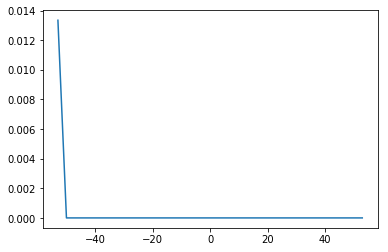

In [40]:
#plotting the predicted function

delta = 3. #increase interval by delta

x_plt = torch.linspace(u-delta, v+delta, m).view(-1,1)
with torch.no_grad():
    y_plt = net(x_plt)

plt.plot(x_plt.numpy(), y_plt.numpy())
plt.show()

In [36]:
for name, param_tensor in net.named_parameters():
        print(name)
        print(param_tensor)

fc1.weight
Parameter containing:
tensor([[ 0.0052],
        [-0.0208]], requires_grad=True)
fc1.bias
Parameter containing:
tensor([-0.0261, -1.0424], requires_grad=True)
fc2.weight
Parameter containing:
tensor([[4.3569e-05, 9.1583e-02]], requires_grad=True)
fc2.bias
Parameter containing:
tensor([5.2854e-08], requires_grad=True)


In [8]:
if logging:
        writer.close()
        !tensorboard --logdir runs 

TensorBoard 1.13.1 at http://vong:6006 (Press CTRL+C to quit)
I0503 14:55:19.542445 140568330999552 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:19] "GET / HTTP/1.1" 200 -
I0503 14:55:19.608771 140568330999552 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:19] "GET /tf-interactive-inference-dashboard/editedexample.png HTTP/1.1" 200 -
I0503 14:55:19.612882 140568372946688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:19] "GET /tf-interactive-inference-dashboard/distance.png HTTP/1.1" 200 -
I0503 14:55:19.614855 140568482002688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:19] "GET /tf-interactive-inference-dashboard/explorecounterfactuals.png HTTP/1.1" 200 -
I0503 14:55:19.618401 140567753254656 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:19] "GET /tf-interactive-inference-dashboard/pdplots.png HTTP/1.1" 200 -
I0503 14:55:20.431128 140568482002688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:20] "GET /data/enviro

I0503 14:55:50.900195 140568330999552 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:50] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May03_14-53-45_vong&experiment= HTTP/1.1" 200 -
I0503 14:55:50.980213 140568372946688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:50] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May03_14-53-45_vong&experiment= HTTP/1.1" 200 -
I0503 14:55:50.980978 140567476426496 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:50] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May03_14-53-45_vong&experiment= HTTP/1.1" 200 -
I0503 14:55:50.981367 140568482002688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:50] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May03_14-53-45_vong&experiment= HTTP/1.1" 200 -
I0503 14:55:50.981991 140567753254656 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:55:50] "GET /data/plugin/scalars/scalars?tag=paramete

I0503 14:56:49.763097 140568372946688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:49] "GET /data/plugin/histograms/histograms?run=May03_14-53-45_vong&tag=fc2.weight HTTP/1.1" 200 -
I0503 14:56:50.503228 140567753254656 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "GET /data/runs HTTP/1.1" 200 -
I0503 14:56:50.503588 140568482002688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "GET /data/environment HTTP/1.1" 200 -
I0503 14:56:50.504485 140567484819200 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "GET /data/experiments HTTP/1.1" 200 -
I0503 14:56:50.504983 140568372946688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "GET /data/plugins_listing HTTP/1.1" 200 -
I0503 14:56:50.517969 140568372946688 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "GET /data/plugin/histograms/tags HTTP/1.1" 200 -
I0503 14:56:50.605828 140567476426496 _internal.py:122] ::ffff:127.0.0.1 - - [03/May/2019 14:56:50] "G